# Third party Data Import - Pleiades, COVID 19

This Jupyter Notebook demonstrates how to import Pleiades data into Sentinel Hub and then access it.
Requirements for the data import:
- AOI - few supermarkets around the Europe, given as geojson file
- all data available in April 2019 
- all data in the period 2020-02-01 - 2020-04-02

We will use **Simple search** and **Order using query**[1].

 
Useful links:  
    [1] TPDI API documentation: https://docs.sentinel-hub.com/api/latest/#/DATA_IMPORT_API/README  
    [2] TPDI API reference (Swagger docs): https://docs.sentinel-hub.com/api/latest/reference/#tag/dataimport_planet  
    [3] Pleaiades User Guide. https://www.cscrs.itu.edu.tr/assets/downloads/PleiadesUserGuide.pdf  
    
Notes:
- Airbus (and consequently SH) charges for each order even if the same data is requested -> do not repeat orders

## Imports and credentials

Before you start an import, please: 
1. fill in **config.py**  file with your credentials
2. set the **collection id** and other setting in the cell starting with _## Settings_
3. If you want to use WFS request in 4.1 you also need to set instance_id and layer in the cell starting with _# Set instance id and layer_

In [22]:
import requests 
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

import json

# Your SH client credentials
from config import * # imports my cliend id and client secret

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)


# Get token for the session
token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

# All requests using this session will have an access token automatically added 
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")
resp.json()

{'sub': '42f086c7-d327-4e93-ac15-48008abf24b2',
 'aud': '24524dc6-7d90-43f1-a61e-a623ecbeb345',
 'jti': 'db6a65eb0e0c35c0f7d476b258de4530',
 'exp': 1586168824,
 'name': 'anja.vrecko@sinergise.com',
 'email': 'anja.vrecko@sinergise.com',
 'sid': '1811c281-283c-4c8a-aff3-a612f3f458be',
 'org': 26,
 'did': 1,
 'd': {'1': {'ra': {'rag': 2, 'ra': {'btc': 1}}, 't': 20000}},
 'active': True}

In [23]:
#Get my quota

url = f"https://services.sentinel-hub.com/dataimport/v1/quotas"

r = oauth.get(url=url)
r.json()

{'member': [{'id': '21d563cb-afae-4129-8557-051b2715da85',
   'quotaSqkm': 30000.0,
   'quotaUsed': 22122.393542350415,
   'datasetId': 'PLANET_SCOPE'},
  {'id': 'c2127557-9078-4932-a4d7-e081f00204af',
   'quotaSqkm': 20000.0,
   'quotaUsed': 579.81,
   'datasetId': 'AIRBUS_PLEIADES'}]}

## Order data import

In [24]:
## Read AOI from file

file_name = "RACE_supermarket_buffer_1.geojson" # set your file name

with open(file_name) as f: # we assigned buffer of cca 1km around given points
    data = json.load(f)

geometries = [ (feature["geometry"], feature["properties"]["CITY"]) for feature in data["features"]]

In [3]:
## Settings
collectionId = ""
skip_names = ["Milan"] # Set the names of geometries, which you wanna skip
area_treshold = 1000 # Set area treshhold in km^2, orders bigger than the treshold will not be confirmed

 # April 2019
#date_from = "2019-04-01T00:00:00.000Z"
#date_to = "2019-05-01T00:00:00.000Z"
#name_sufix = ""

# Today 2020
date_from = "2020-02-01T00:00:00.000Z"
date_to = "2020-04-03T00:00:00.000Z"
name_sufix =", 2020"

In [27]:
## Order import of the data
for geom in geometries:

    geometry = geom[0]
    name = geom[1] + name_sufix
    
    if name in skip_names:
        print (f"{name} skipped.")
        continue

    ### 1 Search
    url = "https://services.sentinel-hub.com/dataimport/v1/search"

    query = {
        "provider": "AIRBUS",
        "bounds": {
            "geometry": geometry
        },
        "data": [
            {
                "constellation": "PHR",
                "dataFilter": {
                    "timeRange": {
                        "from": date_from,
                        "to": date_to
                    }
                }
            }
        ]
    }

    try:
        response = oauth.post(url, json=query)
        response.raise_for_status()
        results=response.json()
    except requests.exceptions.HTTPError as err:
        raise SystemExit(err)

    item_ids = [feature["properties"]["id"] for feature in results["features"]]
    print(f"Search for {name} returns {item_ids}")
    
    if item_ids: 
        ### 2 Order
        url = "https://services.sentinel-hub.com/dataimport/v1/orders"
        
        payload = {
            "name": name,
            "collectionId": collectionId,
            "input": query
        }

        response = oauth.post(url, json=payload)
        response.raise_for_status()
        order = response.json()
        
        order_id = order['id']
        area = order['sqkm']
        print(f"Order {name}, id: {order_id}, area: {area} km^2")
              
        if area < area_treshold:
            ### 3 Confirm
            url = f"https://services.sentinel-hub.com/dataimport/v1/orders/{order_id}/confirm"
            response = oauth.post(url)
            response.raise_for_status()

Search for Athens, 2020 returns ['83b6b7bf-5d97-4054-bfff-3e19dcf98c6c', 'e171d613-87ed-4895-932c-27f5a97cc49c', 'f59a70ab-030e-4c18-a59b-585387d6f288']
Order Athens, 2020, id: b4d7b461-d3eb-4d8f-84e4-ca6e29a8ebe6, area: 12.78
Search for Berlin, 2020 returns ['8eb6d2fb-f508-45ce-a4ce-fa67422a913d', 'edce0675-be97-415b-90a4-c5eaad5fca77']
Order Berlin, 2020, id: 4802ee1e-0b33-406a-95f6-874c69b75a71, area: 9.44
Search for Brussels, 2020 returns ['7890b015-8042-4cd4-92f9-97882a03849c']
Order Brussels, 2020, id: 29653954-2993-4a87-a236-43ea32e542d9, area: 2.1
Search for London, 2020 returns ['16edb6bc-3907-4c96-87ba-7fd804c688d0', '8a0b754e-0850-41e7-8368-a8ae53fb51b4']
Order London, 2020, id: 3f020287-1d39-4c98-80d2-ec72637280a5, area: 9.62
Search for Rome, 2020 returns ['b2a789b1-6e89-468a-ad00-c7861a075011', 'bf2dd578-395a-4c7f-bf2f-8639afc41cc6']
Order Rome, 2020, id: 503e8425-8003-454b-9c91-7be4cfee59bc, area: 9.78
Search for Warsaw, 2020 returns []
Search for Munich, 2020 returns []


In [26]:
# Chek Status
order_id = order_id

url = f"https://services.sentinel-hub.com/dataimport/v1/orders/{order_id}"

response = oauth.get(url)
response.raise_for_status()

order = response.json()
order

{'id': '503e8425-8003-454b-9c91-7be4cfee59bc',
 'userId': '42f086c7-d327-4e93-ac15-48008abf24b2',
 'created': '2020-04-03T09:35:33.733Z',
 'name': 'Rome, 2020',
 'collectionId': '3c4daecf-09f3-451c-8c3c-90e356cbd673',
 'provider': 'AIRBUS',
 'input': {'bounds': {'geometry': {'type': 'Polygon',
    'coordinates': [[[12.560804463221928, 41.885177999999996],
      [12.585804463221926, 41.885177999999996],
      [12.585804463221926, 41.910178],
      [12.560804463221928, 41.910178],
      [12.560804463221928, 41.885177999999996]]]},
   'properties': {}},
  'data': [{'dataFilter': {'timeRange': {'from': '2020-02-01T00:00:00Z',
      'to': '2020-04-03T00:00:00Z'},
     'maxCloudCoverage': 100.0,
     'maxSnowCover': 100.0,
     'maxIncidenceAngle': 90.0},
    'constellation': 'PHR'}],
  'provider': 'AIRBUS'},
 'sqkm': 9.78,
 'status': 'DONE'}

## List all your orders

In [31]:
url = "https://services.sentinel-hub.com/dataimport/v1/orders"

response = oauth.get(url)
response.raise_for_status()

response.json()

## Get the data

In [27]:
# For Rome

minx, miny = data["features"][4]["geometry"]["coordinates"][0][0]
maxx, maxy = data["features"][4]["geometry"]["coordinates"][0][2]

### Which tiles are availbale in my BYOC collection? (WFS request)

In [28]:
# Set instance id nad layer
from xml.etree import ElementTree

base_url = "http://services.sentinel-hub.com/v1/wfs/"
instance_id = "" #id of my configuration instance
type_names = "DSS10-"+collectionId
layer = "" # id of the layer in my configuration instance

url = f"{base_url}{instance_id}?REQUEST=GetFeature&srsName=CRS:84&TYPENAMES={type_names}&BBOX={minx},{miny},{maxx},{maxy}&LAYER={layer}"

r = requests.get(url = url)
#print(r.text) # print the whole response
tree = ElementTree.fromstring(r.text)
tree.getchildren()

[<Element '{http://www.opengis.net/wfs/2.0}boundedBy' at 0x000002307135C598>,
 <Element '{http://www.opengis.net/wfs/2.0}member' at 0x000002307139C9A8>,
 <Element '{http://www.opengis.net/wfs/2.0}member' at 0x00000230713C0318>,
 <Element '{http://www.opengis.net/wfs/2.0}member' at 0x00000230713C0908>]

In [29]:
for member in tree.findall("{http://www.opengis.net/wfs/2.0}member"):
    print(member[0][1].tag, member[0][1].text, member[0][2].tag, member[0][2].text, member[0][3].tag, member[0][3].text )

id ae5059b1-e70d-4a75-9378-be514d21f572 date 2020-03-04 time 10:07:58.1
id bc7865c7-36ec-4824-8bda-389a39622366 date 2020-03-04 time 10:07:39.9
id 6e41c4d2-4eb9-477b-9267-42f2ad76d92f date 2019-04-06 time 10:19:21.5


### Get data with SH process API request

In [30]:
# evalscript
# Band names:  https://developers.planet.com/docs/data/psscene4band/
import os

script = 'airbus_pan.js'
#script = 'planet_ndvi.js'

file_custom_script = 'custom_script/{}'.format(script)
if os.path.isfile(file_custom_script): 
    with open(file_custom_script) as custom_script:
        evalscript = custom_script.read()
        print('Custom script:\n' + evalscript)
else:
    print("Warning: The specified customd script does not exist.")

Custom script:
//VERSION=3
function setup() {
  return {
    input: ["B0", "B1", "B2", "PAN"],
    output: { bands: 3 }
  };
}
let minVal = 0.0;
let maxVal = 3000;
let viz = new DefaultVisualizer(minVal, maxVal);
function evaluatePixel(samples) {
  let sudoPanW = (samples.B1 + samples.B2 + samples.B0) / 3;
  let ratioW = samples.PAN / sudoPanW;
  let val = [samples.B2 * ratioW, samples.B1 * ratioW, samples.B0 * ratioW];
  return viz.processList(val);
}



In [10]:
#sh_date_from = "2019-04-06T00:00:00.000Z"
#sh_date_to =  "2019-04-07T00:00:00.000Z"

sh_date_from = "2020-03-04T00:00:00.000Z"
sh_date_to =  "2020-03-05T00:00:00.000Z"

body = {
    "input": {
        "bounds": {
            "bbox": [minx, miny, maxx, maxy],
            "properties":{
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            }
        },
        "data": [
            {
                "type": "CUSTOM",
                "dataFilter": {
                    "collectionId": collectionId,
                    "timeRange": {
                        "from": sh_date_from,
                        "to": sh_date_to
                    },
                }
            }
        ]
    },
    "evalscript": evalscript,
    "output": {
        "height": 512,
        "width": 512,
        "responses": [
          {
            "identifier": "default",
            "format": {
                  "type": "image/jpeg",
                   "quality": 100
                }
          }
        ]
    }
}

In [162]:
response = oauth.post('https://services.sentinel-hub.com/api/v1/process', json=body)
response.status_code

200

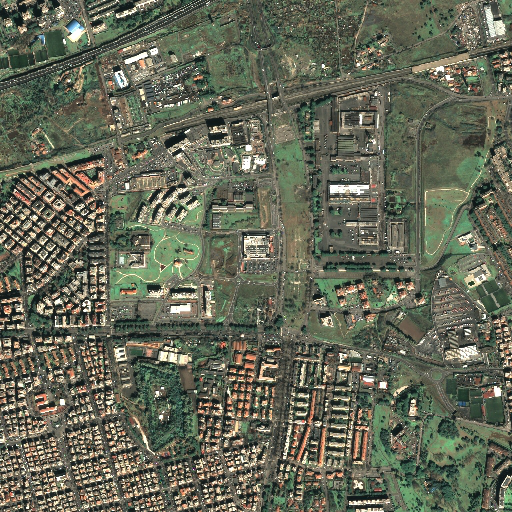

In [160]:
import io
from PIL import Image

stream = io.BytesIO(response.content)
img = Image.open(stream)
img

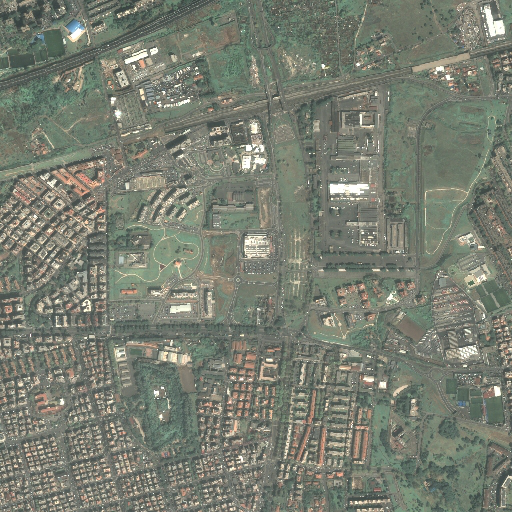

In [163]:
stream = io.BytesIO(response.content)
img = Image.open(stream)
img